# replicate the sine model to check if we can deploy the model onto the MCU

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

import numpy as np
import matplotlib.pyplot as plt
import math
import time

### check if mps support is available -metal performance shaders

In [24]:
torch.backends.mps.is_available()

True

In [25]:
torch.backends.mps.is_built()

True

In [26]:
# we can use it by setting the mps device
mps = torch.device("mps")
cpu = torch.device("cpu")

# create data

In [27]:
SAMPLES = 1000
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

In [28]:
# generate random numbers
x_values = np.random.uniform(low=0, high=2*math.pi, size=SAMPLES)

# shuffle the values
np.random.shuffle(x_values)

# calculate corresponding y values
y_values = np.sin(x_values)

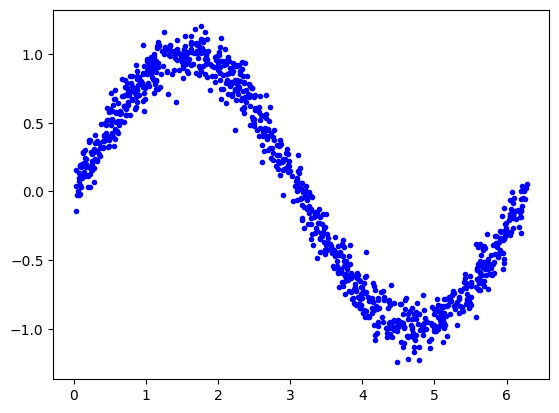

In [29]:
# add noise
y_values += 0.1 * np.random.randn(y_values.shape[0])

plt.plot(x_values, y_values, 'b.')
plt.show()

In [30]:
TRAIN_SPLIT = int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)

x_train, x_validate, x_test = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_validate, y_test = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

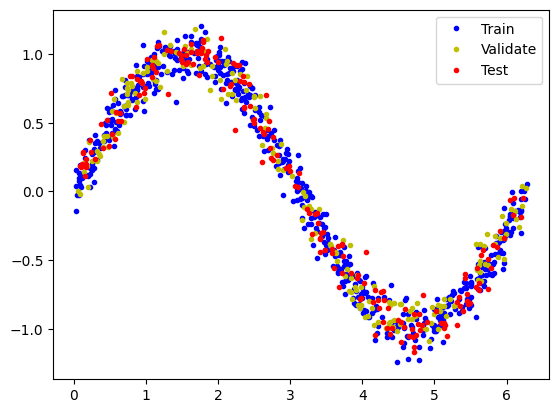

In [31]:
# Plot the data in each partition in different colors:
plt.plot(x_train, y_train, 'b.', label="Train")
plt.plot(x_validate, y_validate, 'y.', label="Validate")
plt.plot(x_test, y_test, 'r.', label="Test")
plt.legend()
plt.show()

# model


In [32]:
# shape should resemble the one used in the tensorflow tutorial

class Mlp(nn.Module):
    def __init__(self):
        super(Mlp, self).__init__()
        # input layer
        self.fc1 = nn.Linear(1, 16)
        # hidden layer
        self.fc2 = nn.Linear(16, 16)
        # output layer, no activation
        self.fc3 = nn.Linear(16, 1)
    
    def forward(self, x):
        # forward loop to propagate through the network
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## implement dataset and data loader

In [33]:
class SineDataset(Dataset):
    
    def __init__(self, data):
         # data is tuple of input and target
        self.x_data = data[0]
        self.y_data = data[1]
        assert len(self.x_data) == len(self.y_data)
        
    def __len__(self):
        return len(self.x_data)
    
    def __getitem__(self, idx):
        # transform data to tensor and unsqueeze to fit the dimensions
        example = torch.unsqueeze(torch.tensor(self.x_data[idx], dtype=torch.float), dim=0)
        target = torch.unsqueeze(torch.tensor(self.y_data[idx], dtype=torch.float), dim=0)
        
        return example, target

In [34]:
def train_with_loader(model, loader, opti, crit, device):
    
    model.to(device)
    
    epoch_train_loss = list()

    for _data in loader:
        # send data to device
        _inpt = _data[0].to(device)
        _trgt = _data[1].to(device)

        # make prediction
        _otp = model(_inpt)
        # compute loss
        loss = crit(_otp.to(device), _trgt).requires_grad_(True)
        # zero out gradients
        opti.zero_grad()
        # backward pass
        loss.backward()       
        # optimization step
        opti.step()

        epoch_train_loss.append(loss.detach().cpu().numpy())

    return model, np.average(epoch_train_loss)

In [35]:
def validate_with_loader(model, loader, device, crit):

    model.to(device)

    val_loss = list()

    for _data in loader:
        # send data to device
        _inpt = _data[0].to(device)
        _trgt = _data[1].to(device)

        # make prediction
        _otp = model(_inpt)
        # compute loss
        loss = crit(_otp.to(device), _trgt)

        val_loss.append(loss.detach().cpu().numpy())
    
    return np.average(val_loss)

In [70]:
EPOCHS = 100
LR = 0.001
BATCH_SIZE = 200
DEVICE = mps

criterion = nn.MSELoss()

# init model and send to desired device
mlp_3 = Mlp()

optimizer = torch.optim.RMSprop(mlp_3.parameters(), lr=LR)

# init datasets
train_ds = SineDataset((x_train, y_train))
val_ds = SineDataset((x_validate, y_validate))

# dataloaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

In [71]:
start = time.time()

train_loss = list()
val_loss = list()

for epoch in range(EPOCHS):
    # training step
    mlp_3.train()
    mlp_3, t_loss_epoch = train_with_loader(mlp_3, train_loader, optimizer, criterion, DEVICE)
    train_loss.append(t_loss_epoch)
    
    # validation step
    mlp_3.eval()
    v_loss_epoch = validate_with_loader(mlp_3, val_loader, DEVICE, criterion)
    val_loss.append(v_loss_epoch)
    
    print(f"EPOCH {epoch+1}: Training loss is {t_loss_epoch:.4f} - Validation loss is {v_loss_epoch:.4f}")

duration = round((time.time() - start), 2)
print(f"That took {duration} seconds")

EPOCH 1: Training loss is 0.6539 - Validation loss is 0.4426
EPOCH 2: Training loss is 0.4029 - Validation loss is 0.3528
EPOCH 3: Training loss is 0.3297 - Validation loss is 0.2989
EPOCH 4: Training loss is 0.2825 - Validation loss is 0.2621
EPOCH 5: Training loss is 0.2476 - Validation loss is 0.2318
EPOCH 6: Training loss is 0.2194 - Validation loss is 0.2081
EPOCH 7: Training loss is 0.1969 - Validation loss is 0.1893
EPOCH 8: Training loss is 0.1794 - Validation loss is 0.1758
EPOCH 9: Training loss is 0.1671 - Validation loss is 0.1661
EPOCH 10: Training loss is 0.1581 - Validation loss is 0.1588
EPOCH 11: Training loss is 0.1511 - Validation loss is 0.1529
EPOCH 12: Training loss is 0.1455 - Validation loss is 0.1480
EPOCH 13: Training loss is 0.1408 - Validation loss is 0.1439
EPOCH 14: Training loss is 0.1367 - Validation loss is 0.1401
EPOCH 15: Training loss is 0.1329 - Validation loss is 0.1365
EPOCH 16: Training loss is 0.1295 - Validation loss is 0.1331
EPOCH 17: Trainin

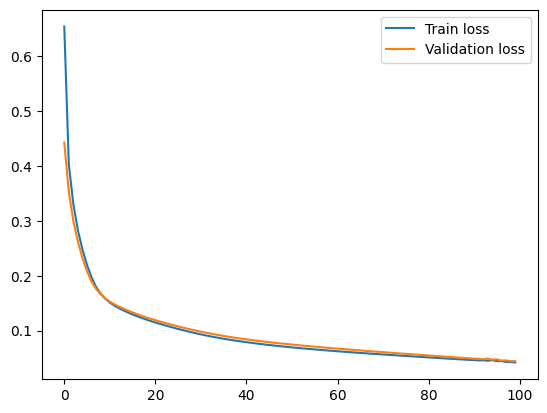

In [72]:
plt.plot(range(EPOCHS),train_loss, label='Train loss')
plt.plot(range(EPOCHS), val_loss, label='Validation loss')
plt.legend()
plt.show()

In [73]:
test_ds = SineDataset((x_test, y_test))
test_loader = DataLoader(test_ds, batch_size=10, shuffle=False)

test_loss = validate_with_loader(mlp_3, test_loader, DEVICE, criterion)

print(test_loss)

0.038196806


### n = 1000

device, bs, time, test-loss
cpu, 1, 10.01
cpu, 50, 0.69, 0.03647747
cpu, 100, 0.58, 0.032128144
cpu, 200, 0.6, 0.033303432
cpu, 400, 0.56, 0.07653184

mps, 1, 174.4, 0.013676792
mps, 50, 4.02, 0.01364733
mps, 100, 2.3, 0.048968475
mps, 200, 1.49, 0.038196806
mps, 400, 1.95, 0.06830369
